# Generating UI (data visualizations) for index.html

In [23]:
import sqlite3
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt


# connect to database

conn = sqlite3.connect("Submission.db")

Idea: Create an interactive bar graph matrix

Based on the attributes, we create a bar graph matrix comparing injury vs non injury based on weather

Each bar graph is then clickable, which opens a secondary stratified line graph (by court type)

In [4]:
# peek datadbase

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

# one table called Data

# read column names
cursor.execute("PRAGMA table_info(Data)")
print(cursor.fetchall())

# print first row
cursor.execute("SELECT * FROM Data LIMIT 1")
print(cursor.fetchall())



[('Data',)]
[(0, 'Date', 'TEXT', 0, None, 0), (1, 'Player', 'TEXT', 0, None, 0), (2, 'Tournament', 'TEXT', 0, None, 0), (3, 'Location', 'TEXT', 0, None, 0), (4, 'Surface', 'TEXT', 0, None, 0), (5, 'Injury', 'INTEGER', 0, None, 0), (6, 'Weather', 'TEXT', 0, None, 0)]
[('2000-01-03', 'Dosedel S.', 'Australian Hardcourt Championships', 'Adelaide', 'Hard', 0, '{"date": "2000-01-03", "weather_code": [3.0], "temperature_2m_max": [25.19649887084961], "temperature_2m_min": [12.796499252319336], "temperature_2m_mean": [18.254831314086914], "daylight_duration": [51965.80859375], "precipitation_sum": [0.0], "rain_sum": [0.0], "snowfall_sum": [0.0], "precipitation_hours": [0.0], "wind_speed_10m_max": [32.73625564575195], "wind_gusts_10m_max": [52.19999694824219], "wind_direction_10m_dominant": [192.07781982421875]}')]


Findings:

1. 0 means not injured, 1 means injured

2. Weather is composed of:

date (YYYY-MM-DD)

weather_code following the pattern:

* 0 = Clear sky
* 1 = Mainly clear
* 2 = Partly cloudy
* 3 = Overcast
* 45 = Fog
* 48 = Depositing Rime Fog
* 51 = Drizzle: Light
* 53 = Drizzle: Moderate
etc .... 

temperature_2m_max (maximum temperature at 2 meters above the ground for the day)

temperature_2m_min
(minimum temperature at 2 meters above the ground for the day)

temperature_2m_mean
(mean temperature at 2 meters above the ground for the day)

daylight_duration
(duration of daylight for the day in seconds)

precipitation_sum
(total amount of precipitation for the day (in milimeters))

rain_sum
(total amount of rain during the day (in milimeters))

snowfall_sum
(total amount of snowfall during the day (in milimeters))

precipitation_hours 
(number of hours during which precipitation was recorded)

wind_speed_10m_max
(maximum wind speed at 10 meters above the ground for the day)

wind_gusts_10m_max
(maximum wind gust at 10 meters above the ground for the day)

wind_direction_10m_dominant
(dominant wind direction at 10 meters above the ground for the day, in degrees)



In [13]:
# print weather data
cursor.execute("SELECT DISTINCT json_extract(Weather, '$.weather_code') FROM Data")
print(cursor.fetchall())

cursor.execute("SELECT DISTINCT json_extract(Weather, '$.weather_code') FROM Data WHERE Injury = 1")
print("Weather codes available for injury data: ", cursor.fetchall())


[('[3.0]',), ('[51.0]',), ('[63.0]',), ('[53.0]',), ('[0.0]',), ('[1.0]',), ('[61.0]',), ('[2.0]',), ('[55.0]',), ('[4.0]',), ('[5.0]',)]
Weather codes available for injury data:  [('[2.0]',), ('[4.0]',), ('[1.0]',), ('[3.0]',), ('[5.0]',)]


Observation:

There are a variety of weather codes, but the added constraint of limited injury data reduces these

To compare, we use only the five injury codes available in the data where Injury = 1 (injured player):

see: https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM

* 1 = Partly cloudy
* 2 = Clear
* 3 = Cloudy
* 4 = Smoky
* 5 = Haze



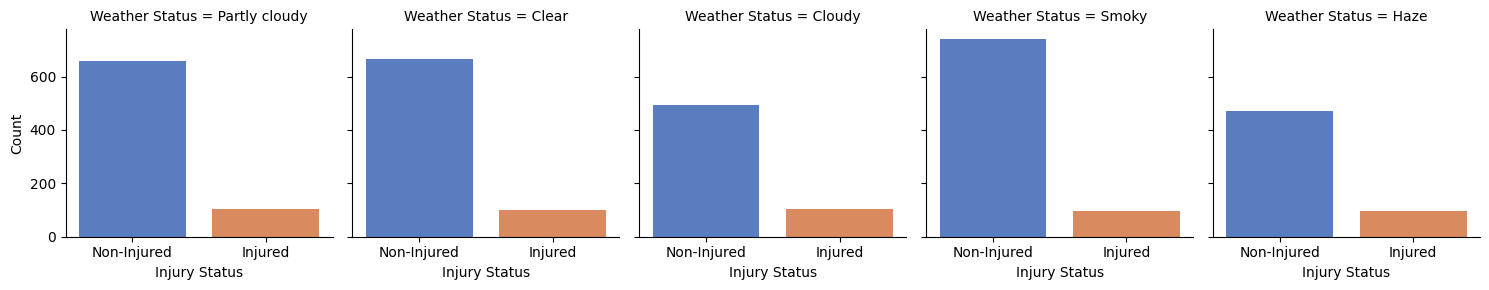

In [ ]:
def bar_by_weather_code(): # graph to plot non-injured (0) vs injured (1) by weather code
    # query 1: get count of non-injured players by weather code
    # we must segment by date because of the limitations of the injured data 
    query = "SELECT json_extract(Weather, '$.weather_code'), COUNT(*) FROM Data WHERE (Injury = 0 AND Date BETWEEN '2022-07-01' AND '2023-02-28') GROUP BY json_extract(Weather, '$.weather_code')"
    cursor.execute(query)
    data = cursor.fetchall()
    
    df1 = pd.DataFrame(data, columns = ['Weather Code', 'Non-Injured'])
    
    # query 2: get count of injured players by weather code
    query = "SELECT json_extract(Weather, '$.weather_code'), COUNT(*) FROM Data WHERE (Injury = 1 AND Date BETWEEN '2022-07-01' AND '2023-02-28') GROUP BY json_extract(Weather, '$.weather_code')"
    cursor.execute(query)
    data = cursor.fetchall()
    
    df2 = pd.DataFrame(data, columns = ['Weather Code', 'Injured'])
    
    # map weather codes to official names
    weather_codes = {'[1.0]': 'Partly cloudy', '[2.0]': 'Clear', '[3.0]': 'Cloudy', '[4.0]': 'Smoky', '[5.0]': 'Haze'}
    
    # merge the two dataframes
    df = pd.merge(df1, df2, on='Weather Code')
    df = pd.melt(df, id_vars = ['Weather Code'], var_name = 'Injury Status', value_name = 'Count')
    
    # df now contains the number of non-injured and injured players by weather code (1,2,3,4,5)
    # augment names
    df['Weather Code'] = df['Weather Code'].map(weather_codes)
    # rename column to "Weather Status"
    df.rename(columns = {'Weather Code': 'Weather Status'}, inplace = True)
    
    # convert dataframe to a dictionary in a more desirable format
    weather_data = df.groupby(['Weather Status', 'Injury Status'])['Count'].sum().unstack().fillna(0).to_dict(orient='index')
    # dump df to JSON for use in index.html
    with open('weather_data.json', 'w') as f:
        json.dump(weather_data, f)
    
    
    # # plot the data as a faceted bar chart
    # graph = sns.FacetGrid(df, col='Weather Status')
    # graph.map(sns.barplot, 'Injury Status', 'Count', hue = 'Injury Status', order=['Non-Injured', 'Injured'], palette='muted', data=df, legend=False)
    
    # plt.tight_layout()
    # plt.show()

bar_by_weather_code()


Plot is ready, and demonstrates a row matrix of graphs split by the weather conditions, and the # of injured or non-injured players in each case

In [7]:
# print unique values for temperature_2m_mean
cursor.execute("SELECT DISTINCT json_extract(Weather, '$.temperature_2m_mean') FROM Data")
print(cursor.fetchall())



[('[18.254831314086914]',), ('[23.79400062561035]',), ('[19.96791648864746]',), ('[18.02750015258789]',), ('[19.307334899902344]',), ('[20.339916229248047]',), ('[19.702085494995117]',), ('[10.078083992004395]',), ('[12.618666648864746]',), ('[9.922831535339355]',), ('[4.915666103363037]',), ('[4.828833103179932]',), ('[26.27491569519043]',), ('[7.0465006828308105]',), ('[20.555999755859375]',), ('[17.3665828704834]',), ('[14.399998664855957]',), ('[10.267748832702637]',), ('[21.5919189453125]',), ('[22.27083396911621]',), ('[18.329416275024414]',), ('[16.197832107543945]',), ('[12.912834167480469]',), ('[11.379916191101074]',), ('[13.382083892822266]',), ('[16.659250259399414]',), ('[14.213749885559082]',), ('[24.53566551208496]',), ('[19.1564998626709]',), ('[19.792085647583008]',), ('[11.217833518981934]',), ('[11.565669059753418]',), ('[18.988832473754883]',), ('[17.0517520904541]',), ('[22.124418258666992]',), ('[24.48682975769043]',), ('[13.970500946044922]',), ('[13.706832885742

In [8]:
def basic_line(): # generic line graph (injuries per court type - 3 layers)
    # Filter only those results from July (07) 2022 to February (02) 2023
    query = "SELECT Surface, Injury FROM Data WHERE Date BETWEEN '2022-07-01' AND '2023-02-28'"

    cursor.execute(query)
    data = cursor.fetchall()

    # counting injuries per surface type
    grouped_data = pd.DataFrame(data, columns = ['Surface', 'Injury']).groupby(['Surface', 'Injury']).size().reset_index(name='Count')

    # extract all the counts for the chart
    count_injured_hard = grouped_data[(grouped_data['Surface'] == 'Hard') & (grouped_data['Injury'] == 1)]['Count'].values[0] 
    count_non_injured_hard = grouped_data[(grouped_data['Surface'] == 'Hard') & (grouped_data['Injury'] == 0)]['Count'].values[0]

    count_injured_clay = grouped_data[(grouped_data['Surface'] == 'Clay') & (grouped_data['Injury'] == 1)]['Count'].values[0]
    count_non_injured_clay = grouped_data[(grouped_data['Surface'] == 'Clay') & (grouped_data['Injury'] == 0)]['Count'].values[0]

    count_injured_grass = grouped_data[(grouped_data['Surface'] == 'Grass') & (grouped_data['Injury'] == 1)]['Count'].values[0]
    count_non_injured_grass = grouped_data[(grouped_data['Surface'] == 'Grass') & (grouped_data['Injury'] == 0)]['Count'].values[0]

    # dump to JSON
    # wrapper for each variable in order to make it JSON serializable

    data = {
        "Hard": {
            "Injured": int(count_injured_hard),
            "Non-Injured": int(count_non_injured_hard)
        },
        "Clay": {
            "Injured": int(count_injured_clay),
            "Non-Injured": int(count_non_injured_clay)
        },
        "Grass": {
            "Injured": int(count_injured_grass),
            "Non-Injured": int(count_non_injured_grass)
        }
    }

    with open("injury_vs_court_type.json", "w") as f:
        json.dump(data, f)
        
basic_line()

In [ ]:
# close connection
conn.close()